## Imports

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import bokeh
import matplotlib as mpl
from matplotlib import rcParams, rc
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator

plt.style.use('/home/imalsky/isaac-style.txt')

In [31]:
from astropy.modeling import models
from astropy import units as u

STELLAR_TEMP  = 6213
bb = models.BlackBody(temperature=STELLAR_TEMP*u.K)

def get_flux(wavelengths):
    black_body_intensity = bb(wavelengths)
    flux = black_body_intensity * np.pi * (1.0/1.0) * u.sr
    return flux.si

In [40]:
from scipy import ndimage

def getSpacing(arr):
    return (arr[-1]-arr[0])/(len(arr)-1)

def fwhm2sigma(fwhm):
    return fwhm / np.sqrt(8 * np.log(2))

def gaussian(x, mu, sig):
    normalization = 1/np.sqrt(2 * np.pi * sig**2)
    exponent = - ((x - mu)**2 / (2*sig**2))
    y = normalization * np.exp(exponent)
    return y

def reduceSpectralResolution(x, y, R_low, R_high=None, lambda_mid=None, n=4):
    if np.ndim(y) == 2:
        return np.array([reduceSpectralResolution(x,spec,R_low,R_high,lambda_mid,n) for spec in y])

    dx = getSpacing(x)
    # If lambda_mid is none, take median of input wavelengths
    if lambda_mid is None:
        lambda_mid = np.median(x)

    # If R_high is none, use midpoint of x divided by spacing in x
    if R_high is None:
        R_high = lambda_mid/dx

    # Create Gaussian kernel
    fwhm = np.sqrt(R_high**2 - R_low**2)*(lambda_mid/(R_low*R_high))
    sigma = fwhm2sigma(fwhm)

    kernel_x = np.arange(-n*sigma, n*sigma+dx, dx)
    kernel = gaussian(kernel_x,0,sigma)
    kernel = kernel/np.sum(kernel)

    # find center of kernel
    n_kernel_lt0 = len(np.where(kernel_x<0)[0])
    n_kernel_gt0 = len(np.where(kernel_x>0)[0])

    if n_kernel_lt0< n_kernel_gt0:
        origin = 0
    else:
        origin=-1

    # convolve
    lowRes = ndimage.convolve(y, kernel, origin=origin)
    return lowRes

## ALL OF THE SPECTRA

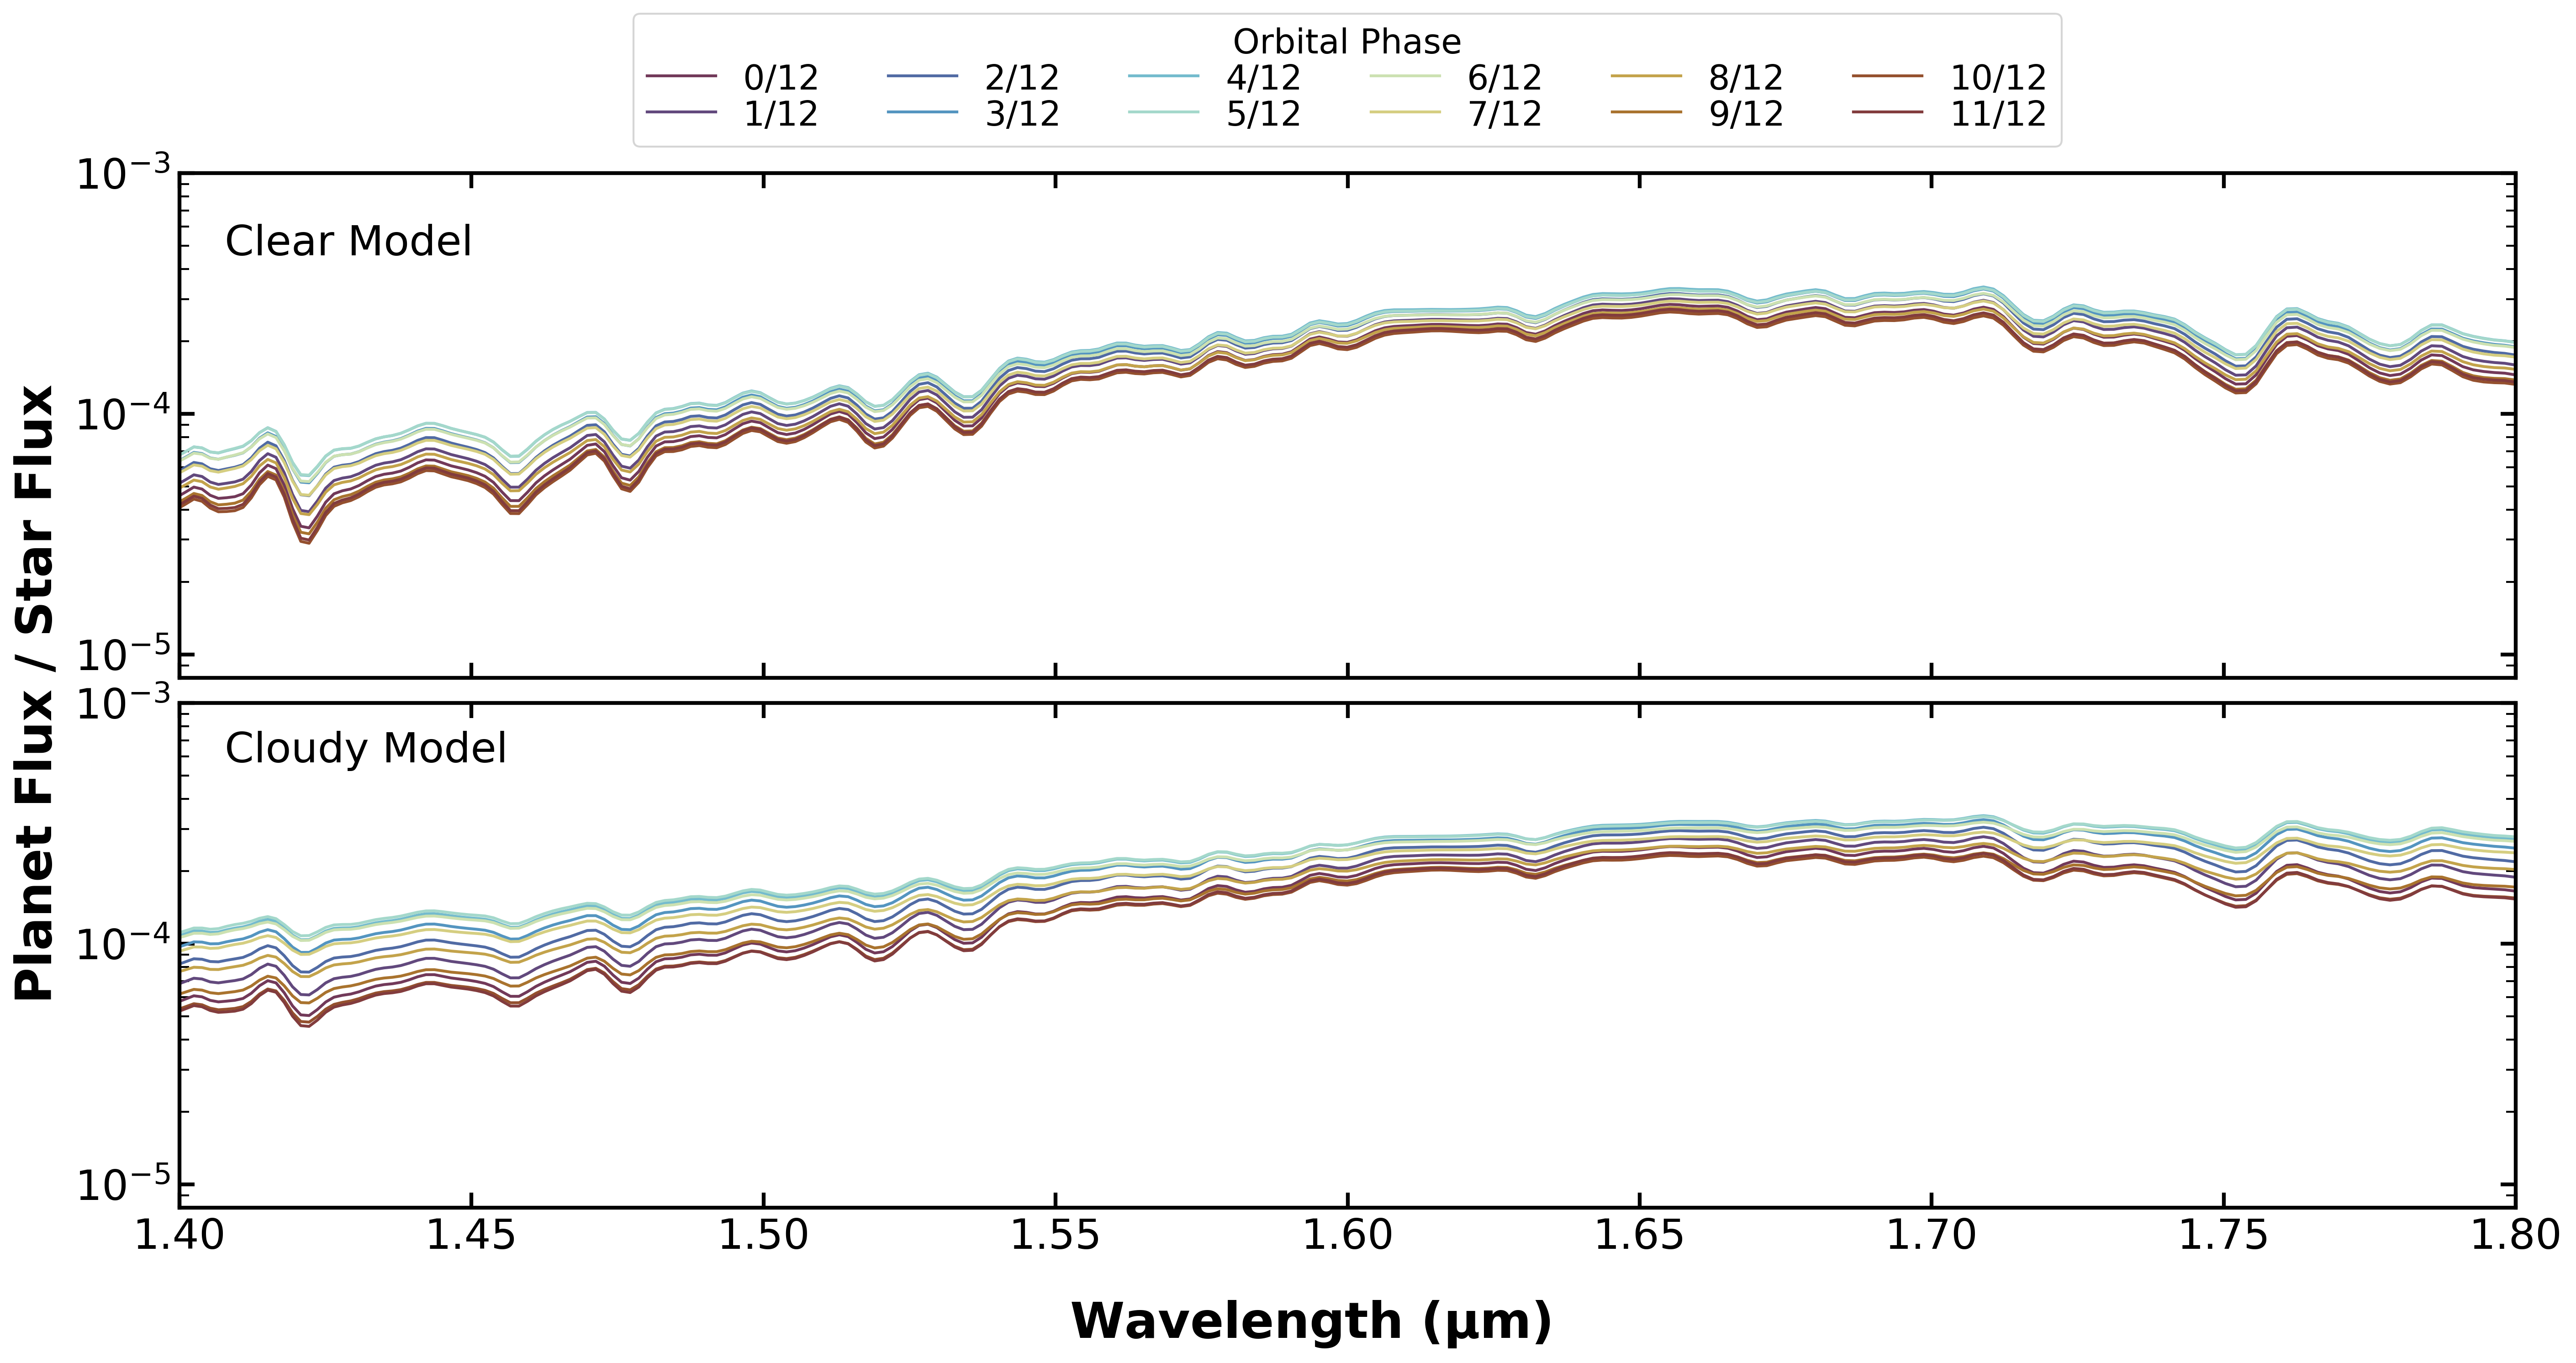

In [49]:
# Figure aesthetics
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(22, 10),sharex=True, sharey=False,squeeze=True)
plt.subplots_adjust(hspace=0.05, wspace=0)

plt.rcParams['legend.title_fontsize'] = 18

models = ['UPS-LOW-G-CLEAR-250', 'UPS-LOW-G-CLOUDY-250']

inclinations = ['1.152']
  
files = ['/home/imalsky/Documents/Tyler-Ups-Work/Spectra/OUT/Spec_{}_{}_phase_0.0_inc_{}0.00.0000.00.dat',
         '/home/imalsky/Documents/Tyler-Ups-Work/Spectra/OUT/Spec_{}_{}_phase_30.0_inc_{}0.00.0000.00.dat',
         '/home/imalsky/Documents/Tyler-Ups-Work/Spectra/OUT/Spec_{}_{}_phase_60.0_inc_{}0.00.0000.00.dat',
         '/home/imalsky/Documents/Tyler-Ups-Work/Spectra/OUT/Spec_{}_{}_phase_90.0_inc_{}0.00.0000.00.dat',
         '/home/imalsky/Documents/Tyler-Ups-Work/Spectra/OUT/Spec_{}_{}_phase_120.0_inc_{}0.00.0000.00.dat',
         '/home/imalsky/Documents/Tyler-Ups-Work/Spectra/OUT/Spec_{}_{}_phase_150.0_inc_{}0.00.0000.00.dat',
         '/home/imalsky/Documents/Tyler-Ups-Work/Spectra/OUT/Spec_{}_{}_phase_180.0_inc_{}0.00.0000.00.dat',
         '/home/imalsky/Documents/Tyler-Ups-Work/Spectra/OUT/Spec_{}_{}_phase_210.0_inc_{}0.00.0000.00.dat',
         '/home/imalsky/Documents/Tyler-Ups-Work/Spectra/OUT/Spec_{}_{}_phase_240.0_inc_{}0.00.0000.00.dat',
         '/home/imalsky/Documents/Tyler-Ups-Work/Spectra/OUT/Spec_{}_{}_phase_270.0_inc_{}0.00.0000.00.dat',
         '/home/imalsky/Documents/Tyler-Ups-Work/Spectra/OUT/Spec_{}_{}_phase_300.0_inc_{}0.00.0000.00.dat',
         '/home/imalsky/Documents/Tyler-Ups-Work/Spectra/OUT/Spec_{}_{}_phase_330.0_inc_{}0.00.0000.00.dat']

labels = ['0/12', '1/12', '2/12', '3/12', '4/12', '5/12', '6/12', '7/12', '8/12', '9/12', '10/12', '11/12']


#buda, batlow, roma, 
cm_name = 'romaO'
cm_file = np.loadtxt(f'/home/imalsky/ScientificColourMaps7/{cm_name}/{cm_name}.txt')
my_colors = mcolors.LinearSegmentedColormap.from_list(cm_name, cm_file[::-1])

num_lines = len(labels)
colors = np.linspace(0, 256, num_lines + 1)

j = 0
for model in models:
    for inc in inclinations:
        i = 0
        for file in files:
               
            data_no_doppler = file.format('0', model, inc)
            color_val = int(colors[i])
            if color_val < 0:
                color_val = color_val + 256            
            
            spectra0 = pd.read_csv(data_no_doppler, header=None, delim_whitespace=True, names=['Wavelength','Flux'])

            STAR_RADIUS   = 1.029e9
            PLANET_RADIUS = 1.220e8
                        
            wavelengths = list(spectra0['Wavelength'][10:-10]) * u.m
            stellar_fluxs = get_flux(wavelengths)
            
            
            x = list(spectra0['Wavelength'][10:-10] * 1e6)
            y = list((PLANET_RADIUS / STAR_RADIUS) ** 2 * (spectra0['Flux'][10:-10] / stellar_fluxs))

            reduced = np.asarray(reduceSpectralResolution(x, y, R_low=190, R_high=None, lambda_mid=None, n=4))
            ax[j].plot(x, reduced, color = my_colors(color_val), label=labels[i])

            
            if j == 0:
                ax[j].legend(fontsize=18, ncol=6,handleheight=1, labelspacing=0.05,
                             loc='upper center', title="Orbital Phase", bbox_to_anchor=(0.5, 1.35))
            
            
            ax[j].set_yscale('log')
            ax[j].set_xlim(1.4, 1.8)
            ax[j].set_ylim(8e-6, 1e-3)
                
            i = i + 1      
        j = j + 1


        
        
fig.text(0.14, 0.82, r"Clear Model", size=22)
fig.text(0.14, 0.45, r"Cloudy Model", size=22)
   
        
fig.text(0.5, 0.03, r"Wavelength ($\mathbf{\mu}$m)", size=26,weight='bold', ha='center')
fig.text(0.07, 0.5, r"Planet Flux / Star Flux", size=26, va='center',weight='bold', rotation='vertical')


plt.savefig('/home/imalsky/Desktop/spectral-lines-190.pdf', dpi=200, bbox_inches='tight')

In [32]:
from astropy.modeling import models
from astropy import units as u

bb_star = models.BlackBody(temperature=6213*u.K)
intensity_star = bb_star(1.6e-6 * u.m)

bb_planet = models.BlackBody(temperature=1300*u.K)
intensity_planet = bb_planet(1.6e-6 * u.m)

print (intensity_star / intensity_planet)

310.13049574262055
